# Pneumonia Detection From Chest X-Ray

## Model Biases and Fairness

This notebook assesses the demographic (gender, age, with/without comorbid diseases, and X-ray view position) biases and fairness of the model.

### Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve

import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import BinaryAccuracy, Precision, Recall

from keras import backend as K
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import VGG16


!pip install aequitas
from aequitas.plotting import Plot
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

Using TensorFlow backend.


Defaulting to user installation because normal site-packages is not writeable


### Load data

In [2]:
df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
df['path'] = df['Image Index'].map(all_image_paths.get)
df.head()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


### Data cleaning

Remove patients with age > 100

In [3]:
df = df[df['Patient Age'] <= 100]
print(df.shape)

(112104, 13)


In [4]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path'],
      dtype='object')

### Drop columns

We will drop columns that we don't need for the analysis

In [5]:
df = df.drop(columns=['Image Index', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'])
df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path
0,Cardiomegaly,0,1,58,M,PA,/data/images_001/images/00000001_000.png
1,Cardiomegaly|Emphysema,1,1,58,M,PA,/data/images_001/images/00000001_001.png
2,Cardiomegaly|Effusion,2,1,58,M,PA,/data/images_001/images/00000001_002.png
3,No Finding,0,2,81,M,PA,/data/images_001/images/00000002_000.png
4,Hernia,0,3,81,F,PA,/data/images_001/images/00000003_000.png


### Add a new Column `pneumonia_class`

In [6]:
df['pneumonia_class'] = df['Finding Labels'].str.contains("Pneumonia")

# convert True/False into Positive/Negative
df['pneumonia_class'] = df['pneumonia_class'].replace({True: "Positive", False: "Negative"})

# number of image that has/doesn't have pneumonia
print("Number of images with pneumonia: {}".format(sum(df['pneumonia_class'] == "Positive")))
print("Number of images without pneumonia: {}".format(sum(df['pneumonia_class'] == "Negative")))

# check df
df.head(5)

Number of images with pneumonia: 1430
Number of images without pneumonia: 110674


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,pneumonia_class
0,Cardiomegaly,0,1,58,M,PA,/data/images_001/images/00000001_000.png,Negative
1,Cardiomegaly|Emphysema,1,1,58,M,PA,/data/images_001/images/00000001_001.png,Negative
2,Cardiomegaly|Effusion,2,1,58,M,PA,/data/images_001/images/00000001_002.png,Negative
3,No Finding,0,2,81,M,PA,/data/images_001/images/00000002_000.png,Negative
4,Hernia,0,3,81,F,PA,/data/images_001/images/00000003_000.png,Negative


### Add a new column `Comorbid`

`Comorbid` is **with_comorbid** if the patient has `Infiltration`, `Edema`, `Effusion`, `Atelectasis`, or `Consolidation`.

`Comorbid` is **no_comorbid** if the patient doesn't have the diseases mentioned above.

These 5 diseases are selected because they are the most common diseases that accompany pneumonia (see EDA notebook).

Also, please note that the definition of the `Comorbid` column also holds for patients who do not have pneumonia.

In [7]:
# with_comorbid is true if the patients have 
df['Comorbid'] = df['Finding Labels'].str.contains("Infiltration|Edema|Effusion|Atelectasis|Consolidation")

# convert True/False into Positive/Negative
df['Comorbid'] = df['Comorbid'].replace({True: "with_comorbid", False: "no_comorbid"})

# number of image that has/doesn't have comorbid
print("Number of images with comorbid: {}".format(sum(df['Comorbid'] == "with_comorbid")))
print("Number of images without comorbid: {}".format(sum(df['Comorbid'] == "no_comorbid")))

# check df
df.head()

Number of images with comorbid: 38298
Number of images without comorbid: 73806


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,pneumonia_class,Comorbid
0,Cardiomegaly,0,1,58,M,PA,/data/images_001/images/00000001_000.png,Negative,no_comorbid
1,Cardiomegaly|Emphysema,1,1,58,M,PA,/data/images_001/images/00000001_001.png,Negative,no_comorbid
2,Cardiomegaly|Effusion,2,1,58,M,PA,/data/images_001/images/00000001_002.png,Negative,with_comorbid
3,No Finding,0,2,81,M,PA,/data/images_001/images/00000002_000.png,Negative,no_comorbid
4,Hernia,0,3,81,F,PA,/data/images_001/images/00000003_000.png,Negative,no_comorbid


### Grouping patient ages

To be consistent with what we did in EDA, we'll group the age of the patients into 0-10, 10-20, ..., 90-100.

In [8]:
# age ranges of each bin
age_bins = list(range(0, 110, 10))
age_mins = np.array(age_bins[:-1])
age_maxs = np.array(age_bins[1:])

bin_names = []
for bin_min, bin_max in zip(age_bins[:-1], age_bins[1:]):
    bmin = str(bin_min)
    bmax = str(bin_max)
    bin_names.append(bmin + "-" + bmax)
    
print("bin_names: {}".format(bin_names))
print("age_mins: {}".format(age_mins))
print("age_maxs: {}".format(age_maxs))


# dict to map bin index to the range of age
age_dict = {}
for i, v in enumerate(bin_names):
    age_dict[i] = v
print("age_dict: {}".format(age_dict))

bin_names: ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
age_mins: [ 0 10 20 30 40 50 60 70 80 90]
age_maxs: [ 10  20  30  40  50  60  70  80  90 100]
age_dict: {0: '0-10', 1: '10-20', 2: '20-30', 3: '30-40', 4: '40-50', 5: '50-60', 6: '60-70', 7: '70-80', 8: '80-90', 9: '90-100'}


In [9]:
# group age into bins
df['Age'] = np.digitize(df['Patient Age'].values, bins=age_bins, right=False)-1
df['Age'] = df['Age'].map(age_dict)

In [10]:
df.sample(5)

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,pneumonia_class,Comorbid,Age
64422,Effusion|Pneumothorax,26,15895,32,M,PA,/data/images_007/images/00015895_026.png,Negative,with_comorbid,30-40
78187,Infiltration,97,19176,66,F,AP,/data/images_009/images/00019176_097.png,Negative,with_comorbid,60-70
80958,Effusion|Mass,3,19894,61,M,PA,/data/images_009/images/00019894_003.png,Negative,with_comorbid,60-70
40755,Effusion,1,10574,53,M,AP,/data/images_005/images/00010574_001.png,Negative,with_comorbid,50-60
54048,Cardiomegaly|Consolidation|Effusion,59,13615,11,F,AP,/data/images_006/images/00013615_059.png,Negative,with_comorbid,10-20


### Data split

We use the same function and random seed to split the data into the training/validation dataset when we trained the model.

In [11]:
def create_splits(df, test_size=0.33, random_state=11):
    """
    Split data into training and testing dataset
    Args:
        df: DataFrame
        test_size: ratio of the test dataset in the range [0, 1] (default=0.33)
        random_state: seed for reproducible shuffling (default=11) 
    """

    np.random.seed(random_state)
    
    # all patient ids
    all_patients = df['Patient ID'].unique()
    
    # patients with pneumonia iamge(s)
    pos_patients = df[df['pneumonia_class']=="Positive"]['Patient ID'].unique()
    # shuffle
    np.random.shuffle(pos_patients)
    # number of patients with pneumonia-positive image
    n_pos = len(pos_patients)
    
    # number of patients in train
    n_pos_train = int(n_pos*(1-test_size))
    n_pos_val = int(n_pos - n_pos_train)
        
    # split into train and testing
    train_ids = pos_patients[:n_pos_train]
    val_ids = pos_patients[n_pos_train:]
    
    # add pneumonia-positive images into the training and validation dataset
    train_data = df[(df['Patient ID'].isin(train_ids)) & (df['pneumonia_class']=="Positive")]
    val_data = df[(df['Patient ID'].isin(val_ids)) & (df['pneumonia_class']=="Positive")]
    
    # number of images in training/validation datasets
    n_train_data = train_data.shape[0]
    n_val_data = val_data.shape[0]
    
    # all patients who don't have pneumonia-positive images
    neg_patients = np.setdiff1d(all_patients, pos_patients)
    
    # shuffle neg_patients
    np.random.shuffle(neg_patients)
    
    # random sample n_train_data patients
    # and select the image they took on their first visit into training dataset
    neg_patients_train = neg_patients[:n_train_data]
    for pid in neg_patients_train:
        train_data = train_data.append(df[(df['Patient ID']==pid) & (df['Follow-up #']==0)])
    
    # random sample 5*n_val_data patients
    # and select the image they took on their first visit into validation dataset
    neg_patients_val = neg_patients[n_train_data: n_train_data + 5*n_val_data]
    for pid in neg_patients_val:
        val_data = val_data.append(df[(df['Patient ID']==pid) & (df['Follow-up #']==0)])
    
    return train_data, val_data

In [12]:
train_data, val_data = create_splits(df)
print("Training data: positive ratio = {:.3f}".format(sum(train_data['pneumonia_class']=="Positive")/train_data.shape[0]))
print("Testing data: positive ratio = {:.3f}".format(sum(val_data['pneumonia_class']=="Positive")/val_data.shape[0]))

Training data: positive ratio = 0.500
Testing data: positive ratio = 0.167


In [13]:
val_data.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,pneumonia_class,Comorbid,Age
48,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,/data/images_001/images/00000013_010.png,Positive,with_comorbid,60-70
126,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,/data/images_001/images/00000032_012.png,Positive,with_comorbid,50-60
614,Atelectasis|Infiltration|Pneumonia,2,150,55,F,AP,/data/images_001/images/00000150_002.png,Positive,with_comorbid,50-60
1073,Pneumonia,2,261,40,F,AP,/data/images_001/images/00000261_002.png,Positive,no_comorbid,40-50
1078,Infiltration|Pneumonia,7,261,41,F,PA,/data/images_001/images/00000261_007.png,Positive,with_comorbid,40-50


### Image augmentations

The cell below implements the augmentation method of data

In [14]:
def my_image_augmentation(train):
    """
    Create ImageDataGenerator with data augmentation for the training and test dataset
    Args:
        train: (bool) indicating whether or not the generator is for training
    Output:
        data_gen: data generator
    """
    if train:
        data_gen = ImageDataGenerator(width_shift_range=[-0.1, 0.1],
                                      height_shift_range=[-0.1, 0.1],
                                      rotation_range=10,
                                      shear_range=10,
                                      zoom_range=0.1,
                                      featurewise_center=True,
                                      featurewise_std_normalization=True)
    else:
        data_gen = ImageDataGenerator(featurewise_center=True,
                                      featurewise_std_normalization=True)
    
    
    data_gen.mean = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
    data_gen.std = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
        
    return data_gen


def make_train_gen(data_gen, df):
    """
    Implementation of the flow_from_dataframe of the traing data generator
    Args:
        data_gen - the training data generator
        df - the dataframe of the training data with paths to the images
    Outputs:
        train_gen - the training data generator
    """
    train_gen = data_gen.flow_from_dataframe(dataframe=df, 
                                             directory=None, 
                                             x_col='path',
                                             y_col='pneumonia_class',
                                             class_mode='binary',
                                             target_size=(224, 224), 
                                             batch_size=64,
                                             shuffle=True)
    return train_gen


def make_val_gen(data_gen, df):
    """
    Implementation of the flow_from_dataframe of the validation data generator
    Args:
        data_gen - the validation data generator
        df - the dataframe of the validation data with paths to the images
    Outputs:
        val_gen - the validation data generator
    """
    val_gen = data_gen.flow_from_dataframe(dataframe=df, 
                                           directory=None, 
                                           x_col='path',
                                           y_col='pneumonia_class',
                                           class_mode='binary',
                                           target_size=(224, 224), 
                                           batch_size=64,
                                           shuffle=False)
    return val_gen

### Create model and load weights

The cells below re-create the VGG-based model we used in training.

In [15]:
def build_my_model():
    """
    Build the model from Keras for image classification (using pre-trained VGG)
    """
    # create the model
    model = keras.Sequential(name='model')
    
    # load pretrained VGG16 (include_top=True)
    vgg16 = VGG16(include_top=True, weights='imagenet')
    
    # add all layers except for the last (dense) layer of vgg into model
    for vgg_layer in vgg16.layers[:-1]:
        model.add(vgg_layer)
        
    # (d=4096)
    # add a dropout layer and a final layer for binary classification
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    # freeze all layers
    for layer in model.layers:
        layer.trainable = False
    
    # optimizer
    opt = keras.optimizers.Adam(learning_rate=5e-5)
    
    # metrics
    metrics = [BinaryAccuracy(name='acc')]
    
    # compile
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
    
    return model

In [16]:
# create model
model = build_my_model()
# load weights
model.load_weights('./xray_class_my_model.best.hdf5')
# print model summary
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
____________________________________________________________

### Model prediction on the validation dataset

We use the trained model to predict on the validation dataset. After outputing a score, we use threshold value **0.2768** to classify the results into `with pneumonia` and `no pneumonia`. The threshold value was selected by the methods described in the notebook `Build and train model`.

In [17]:
# create validation data generator
val_gen = make_val_gen(my_image_augmentation(train=False), val_data)

# reset generator
val_gen.reset()

# actual labels
y_true = np.array(val_gen.classes)
print(y_true)

# predict on validation data
pred_Y = model.predict_generator(val_gen, steps=int(np.ceil(val_gen.n/val_gen.batch_size)), verbose=1)
y_score = np.squeeze(pred_Y)
print(y_score)

Found 2850 validated image filenames belonging to 2 classes.
[1 1 1 ... 0 0 0]
45/45 [==============================] - 61s 1s/step
[0.8348358  0.95136917 0.6688905  ... 0.08948319 0.9534876  0.28704643]


### Using Aequitas for biases and fairness analysis

The procedures below follow the [Aequitas tutorial](https://dssg.github.io/aequitas/examples/compas_demo.html).

In [18]:
# use a dataframe copy
val_df = val_data.copy()
val_df = val_df.drop(columns=['Patient Age', 'Finding Labels', 'Follow-up #', 'Patient ID', 'path'])
val_df.head()

,Patient Gender,View Position,pneumonia_class,Comorbid,Age
48,M,AP,Positive,with_comorbid,60-70
126,F,AP,Positive,with_comorbid,50-60
614,F,AP,Positive,with_comorbid,50-60
1073,F,AP,Positive,no_comorbid,40-50
1078,F,PA,Positive,with_comorbid,40-50


In [19]:
# the threshold value for binary classification
THRESHOLD = 0.2768

# create a `score` column
val_df['score'] = np.array(y_score) > THRESHOLD
val_df['score'] = val_df['score'].replace({True: 1, False: 0})

# rename column `pneumonia_class` to `label_value`
val_df = val_df.rename(columns={"pneumonia_class": "label_value"})
val_df['label_value'] = val_df['label_value'].replace({"Positive": 1, "Negative": 0})

val_df.head()

,Patient Gender,View Position,label_value,Comorbid,Age,score
48,M,AP,1,with_comorbid,60-70,1
126,F,AP,1,with_comorbid,50-60,1
614,F,AP,1,with_comorbid,50-60,1
1073,F,AP,1,no_comorbid,40-50,1
1078,F,PA,1,with_comorbid,40-50,1


In [20]:
# calculate absolute group metrics
g = Group()
xtab, _ = g.get_crosstabs(val_df)

model_id, score_thresholds 1 {'rank_abs': [477]}


### Biases analysis

In [21]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab,
                                        original_df=val_df, 
                                        ref_groups_dict={'View Position': 'AP',
                                                         'Patient Gender': 'M',
                                                         'Age': '40-50',
                                                         "Comorbid": "no_comorbid"}, 
                                        alpha=0.05, 
                                        check_significance=False)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)


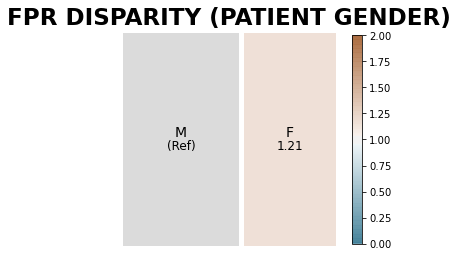

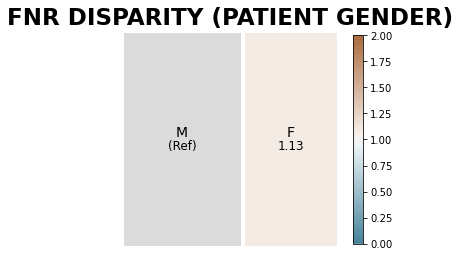

In [22]:
aqp = Plot()
# Gender
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='Patient Gender')
aqp.plot_disparity(bdf, group_metric='fnr_disparity', attribute_name='Patient Gender')

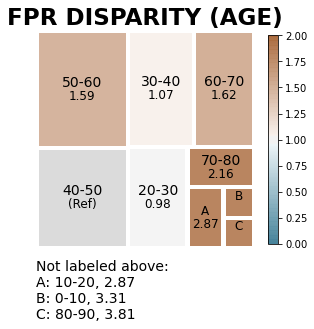

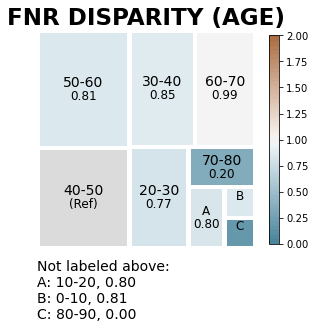

In [23]:
# Age
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='Age')
aqp.plot_disparity(bdf, group_metric='fnr_disparity', attribute_name='Age')

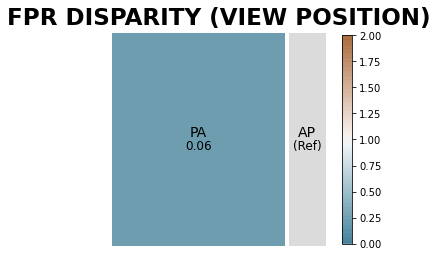

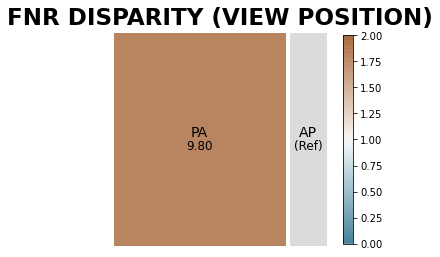

In [24]:
# View Position
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='View Position')
aqp.plot_disparity(bdf, group_metric='fnr_disparity', attribute_name='View Position')

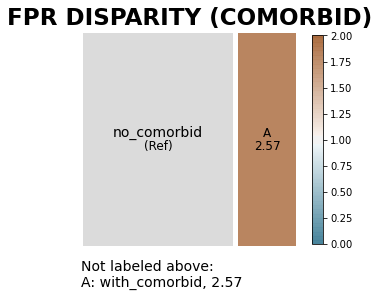

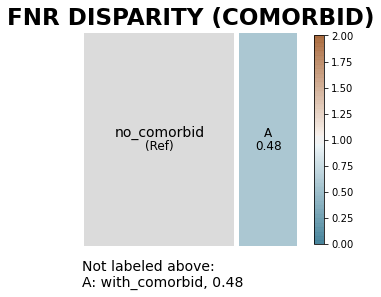

In [25]:
# View Position
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='Comorbid')
aqp.plot_disparity(bdf, group_metric='fnr_disparity', attribute_name='Comorbid')

### Fairness analysis

In [26]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


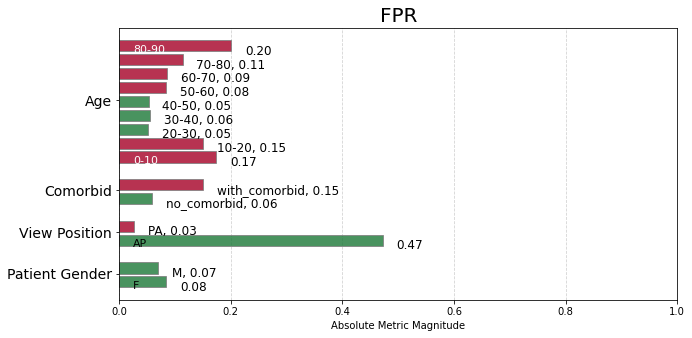

In [27]:
# false positive rate
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

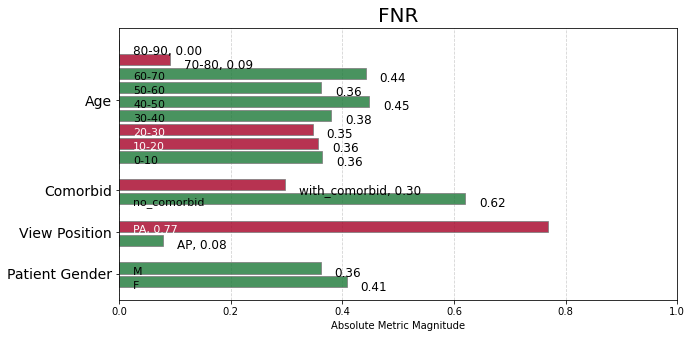

In [28]:
# false negative rate
fnr_fairness = aqp.plot_fairness_group(fdf, group_metric='fnr', title=True)